In [2]:
import os
import jCMIP as jc
Clist = jc.readList(('CMIP6listnew'))

from netCDF4 import Dataset
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import cftime
%matplotlib inline

#### Plot variables (T,S,v,tau) - single model

/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y h

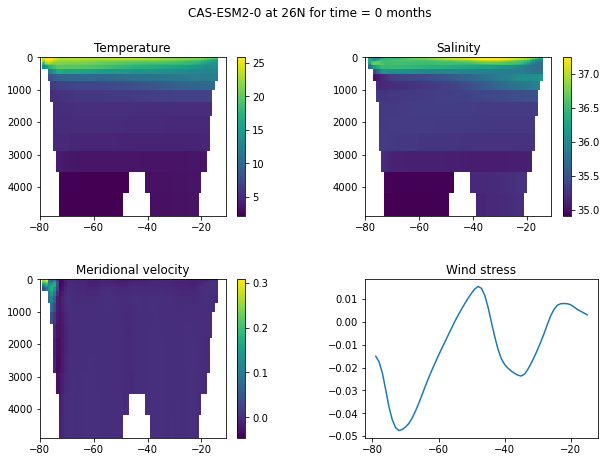

In [5]:
#Select model
model = Clist['CAS-ESM2-0']
EXP   = 'historical'
ENS   = 'r1i1p1f1'

outfile = ('/home/users/jordi/section26data/' + model.name + '_' + EXP + '_' + ENS + '.nc')
ncid = Dataset(outfile,'r')

#Read variables
t    = ncid.variables['thetao'][:,:,0,:]
s   = ncid.variables['so'][:,:,0,:]
v    = ncid.variables['vo'][:,:,0,:]
tau  = ncid.variables['tauuo'][:,0,:]
lev  = ncid.variables['lev'][:]
lon  = np.squeeze(ncid.variables['lon'][:,:])
ncid.close()

time = 0
fig = plt.figure(figsize=(10,7))
fig.suptitle(model.name + ' at 26N for time = ' + str(time) + ' months')
plt.subplot(2,2,1)
plt.pcolormesh(lon,lev,t[time,:,:])
plt.gca().invert_yaxis()
plt.title('Temperature')
plt.colorbar()
plt.subplot(2,2,2)
plt.pcolormesh(lon,lev,s[time,:,:])
plt.gca().invert_yaxis()
plt.title('Salinity')
plt.colorbar()
plt.subplot(2,2,3)
plt.pcolormesh(lon,lev,v[time,:,:])
plt.gca().invert_yaxis()
plt.title('Meridional velocity')
plt.colorbar()
plt.subplot(2,2,4)
plt.plot(lon,tau[time,:])
plt.title('Wind stress')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

#### Plot meridional transport and boundaries (CAS-ESM2-0)

/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Warning: converting a masked element to nan.
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:102: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.5, 1.0, 'Meridional velocity')

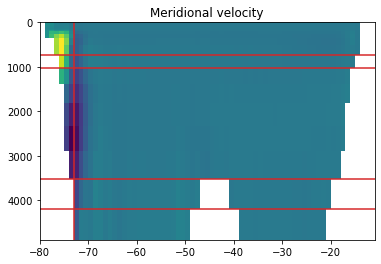

In [4]:
#Select model
model = Clist['CAS-ESM2-0']
EXP   = 'historical'
ENS   = 'r1i1p1f1'

outfile = ('/home/users/jordi/section26data/' + model.name + '_' + EXP + '_' + ENS + '.nc')
ncid = Dataset(outfile,'r')

#Read variables
T    = ncid.variables['thetao'][:,:,0,:]
SP   = ncid.variables['so'][:,:,0,:]
v    = ncid.variables['vo'][:,:,0,:]
tau  = ncid.variables['tauuo'][:,0,:]
lev  = ncid.variables['lev'][:]
lon  = np.squeeze(ncid.variables['lon'][:,:])
lat  = np.squeeze(ncid.variables['lat'][:,:])
ilat = int(ncid.variables['ilat'][:])          #Change ilat from float to int
dx   = ncid.variables['dx'][0,:]
dz   = ncid.variables['dz'][:,0,:]
#tp85 = ncid.variables['tp85_BS'][:,:,:]
tp10 = ncid.variables['tp10'][:,:,:]
#tp   = ncid.variables['tp'][:,:]
vmask = ncid.variables['vmask'][:,:,:]
ncid.close()

#Ekman calculation
f = 2*7.2921e-5*np.sin(lat[0]*np.pi/180)
rho = 1026

ektp = np.zeros(np.shape(tau))
ek = np.zeros(np.shape(tau))
for i in range (len(tau[:,0])):
    for j in range (len(lon)):
        ektp[i,j] = -tau[i,j]/(f*rho)
        ek[i,j]   = ektp[i,j]*dx[j]*1e-6         #v = taux/(rho*f*H), so tp = v*H*L = taux*L/(rho*f)
    
ektot = np.nansum(ek,axis=1)
    
time10 = 129
tp10   = np.nanmean(tp10,axis=0)

fs10v = np.zeros(time10)
AABW10v = np.zeros(time10)
lNADW10v = np.zeros(time10)
uNADW10v = np.zeros(time10)
iw10v = np.zeros(time10)
tr10v = np.zeros(time10)
ek10 = ektot[-129::]
tr10testv = np.zeros(time10)
ek10testv = np.zeros(time10)   

#imax
tprow10 = np.nansum(tp10[:,:],axis=1)
mocbtv  = -1*np.nancumsum(tprow10[::-1])[::-1]
ilevmin = np.nanargmin(np.abs(lev-200))         #Find index where lev = 200, so outlier where imax = 0 is solved
ilevmax = np.nanargmin(np.abs(lev-2000))         #Find index where lev = 2000, so outlier where imax = -1 is solved
imax2   = np.where(mocbtv[ilevmin:ilevmax] == max(mocbtv[ilevmin:ilevmax]))
imax1   = imax2[0]
imax    = imax1[0] + ilevmin                       #+ilevmin since imax[0] = mocbtv[ilev]
        
imaxtest2   = np.where(mocbtv == max(mocbtv))
imaxtest1   = imaxtest2[0]
imaxtest    = imaxtest1[0]
        
if imax != imaxtest:
    print(str(model.name) + ' - ' + str(lev[imax]))
            
#Find FS boundary
tpcol10 = np.nansum(tp10[0:imax,:],axis=0)
mx     = np.nanargmin(np.abs(tpcol10 - max(tpcol10)))
idx2   = np.where(tpcol10[mx::]<0)                      #Make sure idx > mx (max(tpcol10))
idx1   = idx2[0]
idx = idx1[0] + mx
        
tprow_upmo10v    = np.nansum(tp10[:,idx::],axis=1)
tprow_lowmo10v   = np.nansum(tp10[:,:],axis=1)
        
#PT = 8
T10  = np.nanmean(T[-129::,:,:],axis=0)
PTrow = np.nanmean(T10[:,:],axis=-1)
PT8idx = np.nanargmin(np.abs(PTrow-8))
              
if PT8idx > imax:                                       #Make sure PT8 !> imax
    PT8idx = imax

#PT = 3
PT3idx = np.nanargmin(np.abs(PTrow-3))
    
#Aidx
for m in range (1,len(tprow_lowmo10v)):                    #start at 1, otherwise the first and last point will be compared
    if tprow_lowmo10v[m]>0 and tprow_lowmo10v[m-1]<0:
        Aidx = m
                
AABWcheck = tprow_lowmo10v[int(Aidx)::]                    #Make sure sum(AABW) is positive
if sum(AABWcheck) < 0:
    Aidx = len(tprow_lowmo10v) - 1
            
if PT3idx > Aidx:                                       #Make sure PT3 !> Aidx
    PT3idx = Aidx 
    
plt.figure(1)
plt.pcolormesh(lon,lev,tp10[:,:])
plt.axvline(x=lon[idx],color='C3',label='ifs')
plt.axhline(y=lev[imax],color='C3',label='imax')
plt.axhline(y=lev[PT8idx],color='C3',label='PT8')
plt.axhline(y=lev[PT3idx],color='C3',label='PT3')
plt.axhline(y=lev[Aidx],color='C3',label='Aidx')
plt.gca().invert_yaxis()
plt.title('Meridional velocity')

/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


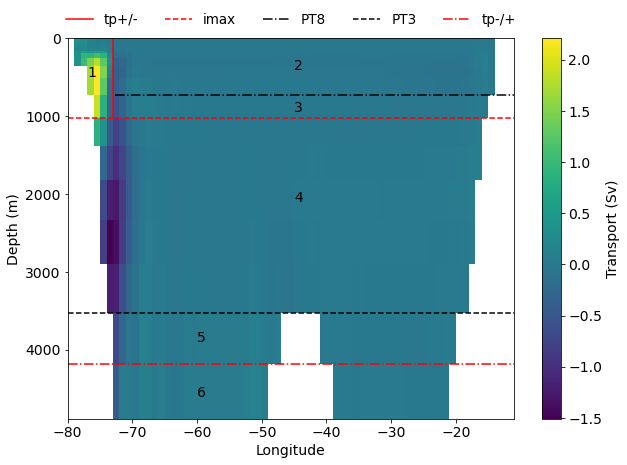

In [9]:
plt.figure(1,figsize=(10,7))
plt.pcolormesh(lon,lev,tp10[:,:])
plt.axvline(x=lon[idx],ymin=1,ymax=1-lev[imax]/lev[-1],color='r',linestyle='-',label='tp+/-')
plt.axhline(y=lev[imax],color='r',linestyle='--',label='imax')
plt.axhline(y=lev[PT8idx],xmin=0.105,xmax=1,color='k',linestyle='-.',label='PT8')
plt.axhline(y=lev[PT3idx],color='k',linestyle='--',label='PT3')
plt.axhline(y=lev[Aidx],color='r',linestyle='-.',label='tp-/+')
plt.gca().invert_yaxis()
#plt.title('Mean transport')
plt.annotate('1',(-77,500),fontsize=14)
plt.annotate('2',(-45,400),fontsize=14)
plt.annotate('3',(-45,950),fontsize=14)
plt.annotate('4',(-45,2100),fontsize=14)
plt.annotate('5',(-60,3900),fontsize=14)
plt.annotate('6',(-60,4600),fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Depth (m)',fontsize=14)
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.1),ncol = 5,prop={'size': 13.5},frameon=False)
cbar = plt.colorbar()
cbar.set_label('Transport (Sv)',size=14)
cbar.ax.tick_params(labelsize=14) 

#### Check depth of maximum overturning - single model

/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


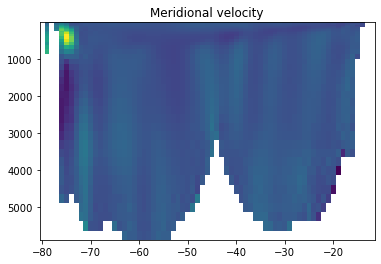

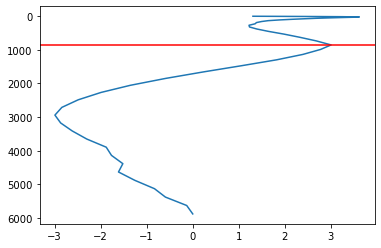

In [3]:
# All models: ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
# 'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']

#Select model
model = Clist['NESM3']
EXP   = 'ssp585'
ENS   = 'r1i1p1f1'

outfile = ('/home/users/jordi/section26data/' + model.name + '_' + EXP + '_' + ENS + '.nc')
ncid = Dataset(outfile,'r')

#Read variables
t    = ncid.variables['thetao'][:,:,0,:]
s    = ncid.variables['so'][:,:,0,:]
v    = ncid.variables['vo'][:,:,0,:]
tau  = ncid.variables['tauuo'][:,0,:]
lev  = ncid.variables['lev'][:]
lon  = ncid.variables['lon'][:,:]
lat  = ncid.variables['lat'][:,:]
ilat = int(ncid.variables['ilat'][:])          #Change ilat from float to int
dx   = ncid.variables['dx'][0,:]
dz   = ncid.variables['dz'][:,0,:]
tp85 = ncid.variables['tp85BS'][:,:,:]
#tp10 = ncid.variables['tp10'][:,:,:]
#tp   = ncid.variables['tp'][:,:]
vmask = ncid.variables['vmask'][:,:,:]
ncid.close()

i = 845

plt.figure(1)
plt.pcolormesh(lon,lev,tp85[i,:,:])
plt.gca().invert_yaxis()
plt.title('Meridional velocity')

tprow85 = np.nansum(tp85[i,:,:],axis=1)
mocbtv  = -1*np.nancumsum(tprow85[::-1])[::-1]

ilevmin = np.nanargmin(np.abs(lev-200))         #Find index where lev = 200, so outlier where imax = 0 is solved
ilevmax = np.nanargmin(np.abs(lev-2000))         #Find index where lev = 2000, so outlier where imax = -1 is solved
        
if model.name == 'NESM3':                     #NESM3 has a peak in overturning at surface up till depths of ~700m
    ilevmin = np.nanargmin(np.abs(lev-800))

if model.name == 'HadGEM3-GC31-MM':                     #HadGEM3-GC31-MM has a peak in overturning at surface up till depths of ~450m
    ilevmin = np.nanargmin(np.abs(lev-450))    
    
imax2   = np.where(mocbtv[ilevmin:ilevmax] == max(mocbtv[ilevmin:ilevmax]))
imax1   = imax2[0]
imax    = imax1[0] + ilevmin

plt.figure(3)
plt.plot(mocbtv,lev)
plt.axhline(lev[imax],color='r')
plt.gca().invert_yaxis()

#### Compare calculated and given stream function

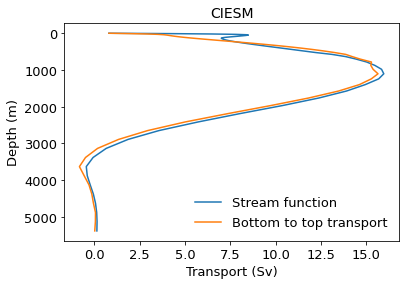

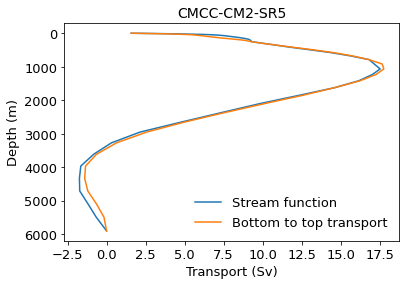

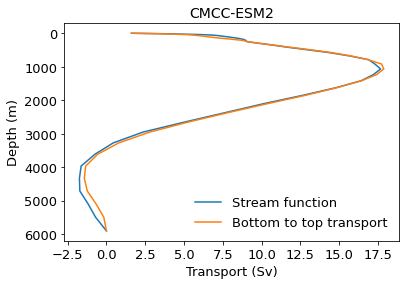

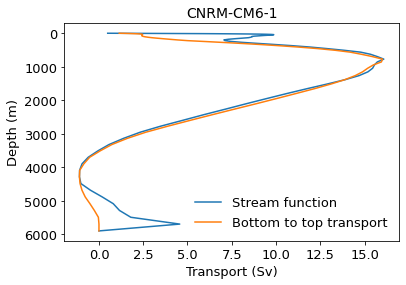

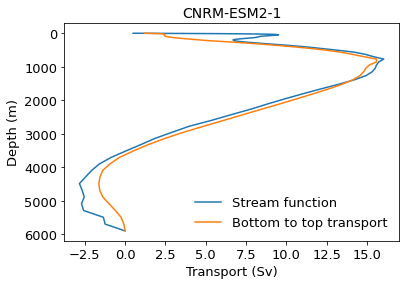

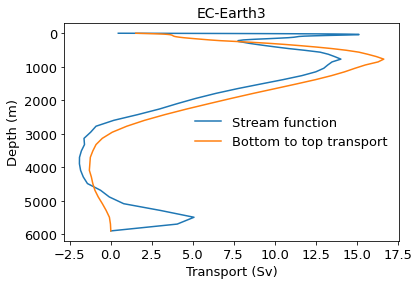

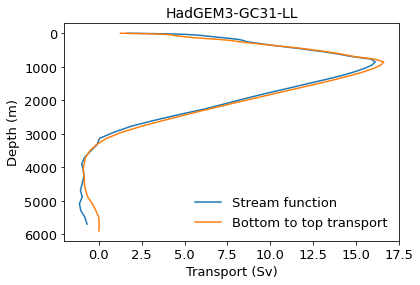

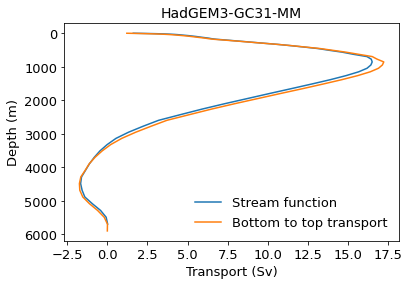

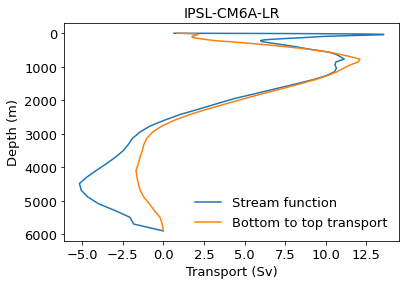

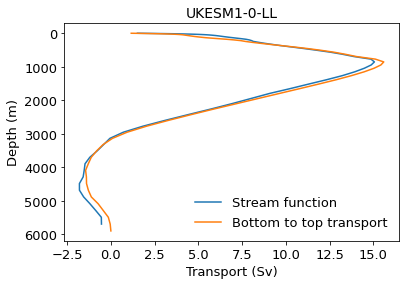

In [4]:
totmod =  ['CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','EC-Earth3',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r2i1p1f2','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f2']
EXP   = 'historical'

for i in range(len(totmod)):
    model = Clist[totmod[i]]
    outfile = ('/home/users/jordi/section26data/' + model.name + '_' + EXP + '_' + ENS[i] + '.nc')
    ncid = Dataset(outfile,'r')
    lev  = ncid.variables['lev'][:]
    ilat = int(ncid.variables['ilat'][:])
    ncid.close()

    #Calculate stream function data
    SFFiles = model.getFiles('msftyz', EXP=EXP,ENS=ENS[i],vtype='Omon',gtype='gn')
    ncid = Dataset(SFFiles[0],'r')
    msftyz = ncid.variables['msftyz'][:,0,:,ilat]
    ncid.close()
        
    sfmean   = np.mean(msftyz,axis=0)/(1026e6)        #Convert from kg/s to Sv

    ncid = Dataset('totaltp.nc','r')
    tp   = ncid.variables[model.name][:,:]
    ncid.close()

    #Calculate total transport of each depth level along the entire section
    tprow = np.nansum(tp,axis=1)
    moctb = np.cumsum(tprow)                   #Top to bottom
    mocbt = -1*np.cumsum(tprow[::-1])[::-1]    #Bottom to top

    plt.figure(i)
    if len(sfmean) == len(mocbt):
        plt.plot(sfmean,lev,label='Stream function')
        plt.plot(mocbt,lev,label='Bottom to top transport')
    else:
        plt.plot(sfmean[0:-1],lev,label='Stream function')
        plt.plot(mocbt,lev,label='Bottom to top transport')        
    plt.gca().invert_yaxis()
    plt.title(totmod[i],fontsize=14)
    plt.xlabel('Transport (Sv)',fontsize=13)
    plt.xticks(fontsize=13)
    plt.ylabel('Depth (m)',fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend(prop={'size': 13},frameon=False)